# Houses Price Prediction using Stacked Regression - Hyperparameter Optimization for Lasso, ElasticNet and KernelRidge regression models. 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


house-prices-advanced-regression-techniques

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


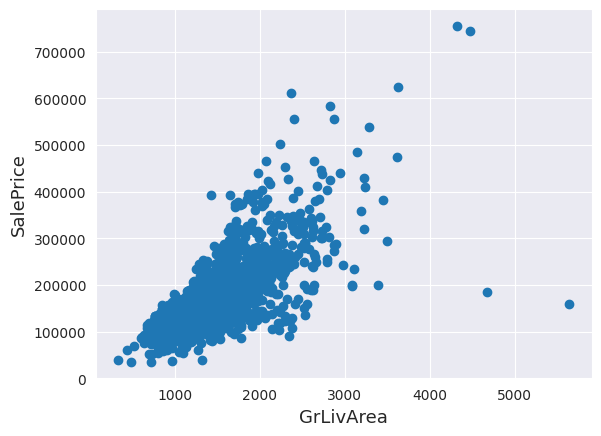

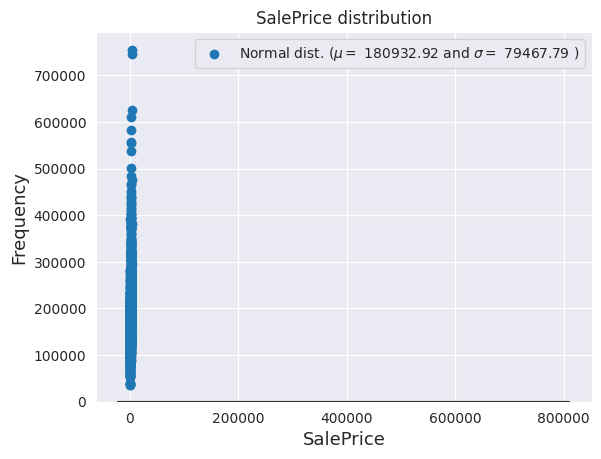

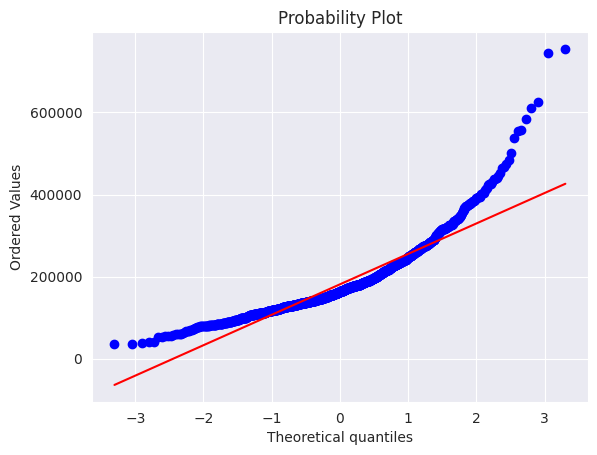

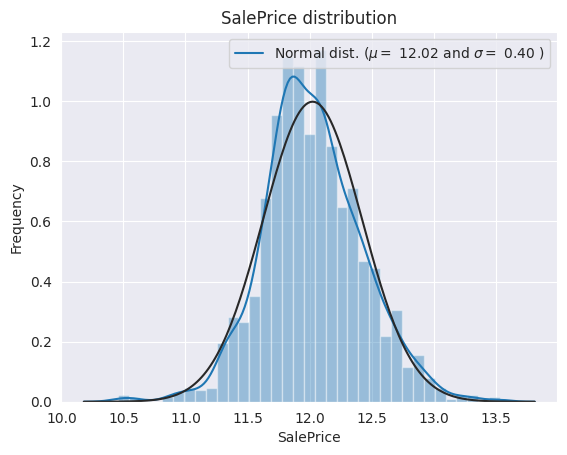

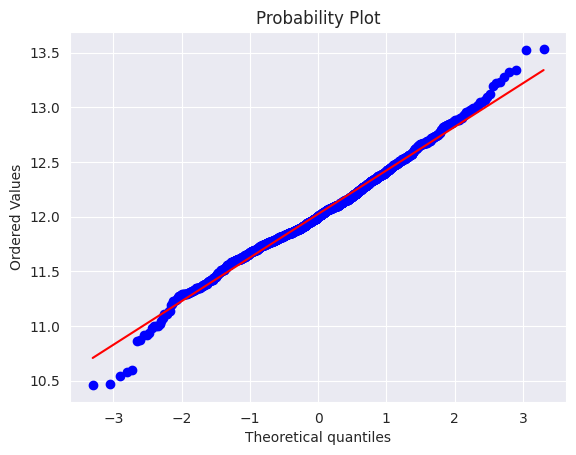

all_data size is : (2917, 79)
Shape all_data: (2917, 78)

Skew in numerical features: 

There are 59 skewed numerical features to Box Cox transform

Skew in numerical features: 

(2917, 220)


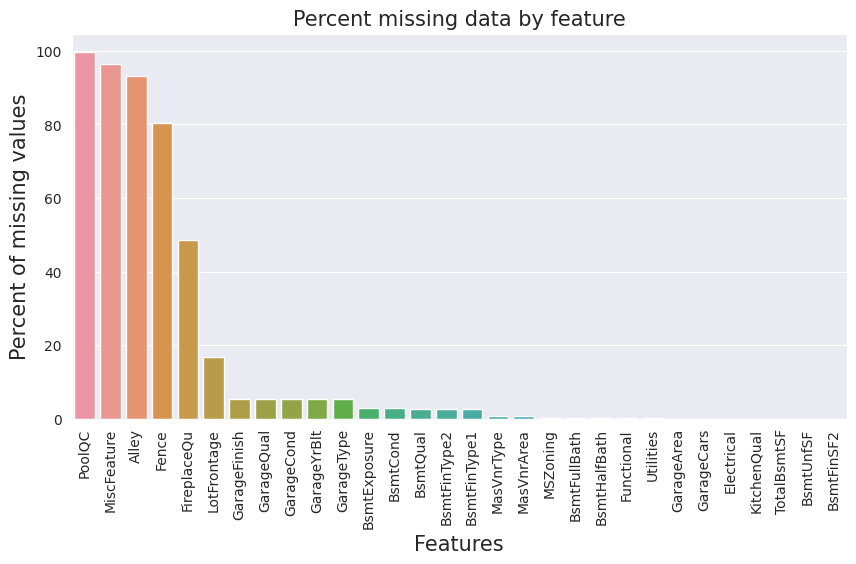

In [1]:
# ===============================================================================================================================
#                                                   IMPORT LIBRARIES
# ===============================================================================================================================

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore")
from scipy import stats
from scipy.stats import norm, skew #for some statistics



from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

# ===============================================================================================================================
#                                                       READ DATA
# ===============================================================================================================================
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

# Display the first five rows of the train dataset.
train.head(5)

# ===============================================================================================================================
#                                               NUMBER OF SAMPLES and FEATURES.
#                                                   Drop the 'Id' Column
# ===============================================================================================================================
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

# ===============================================================================================================================
#                                                    I.1. REMOVE THE OUTLIERS
# ===============================================================================================================================

# Find the outliers
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

# ===============================================================================================================================
#                                             I.2. TARGET VARIABLE ANALYSIS ('SalePrice')
# ===============================================================================================================================
# We want to predict SalePrice variable. 
# First, let's do some analysis on this variable.

sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

# ===============================================================================================================================
#                                             I.3. TARGET VARIABLE ANALYSIS ('SalePrice')
#                                                  Log-Transformation of 'SalePrice'
# ===============================================================================================================================

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

# Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

# ===============================================================================================================================
#                                                     I.4. FEATURES ENGINEERING
#                                                           Concatenation
# ===============================================================================================================================

# Concatenate train and test data in the same dataframe
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

# ===============================================================================================================================
#                                                     I.5. FEATURES ENGINEERING
#                                                          Missing Data
# ===============================================================================================================================

# Compute the Missing Ratio for all features, then plot it
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# ===============================================================================================================================
#                                                     I.6. FEATURES ENGINEERING
#                                                  Imputation of the Missing Data
# ===============================================================================================================================

# 'PoolQc' : NA means "No Pool"
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
# 'MiscFeature' : NA means "no misc feature"
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
# 'Alley' : NA means "no alley access"
all_data["Alley"] = all_data["Alley"].fillna("None")
# 'Fence' : NA means "no fence"
all_data["Fence"] = all_data["Fence"].fillna("None")
# 'FirePlaceQu' : NA means "no fireplace"
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

# 'LotFrontage' : We can fill in missing values by the median 'LotFrotnage' of the neighborhood. 
# Indeed, since the area of each street connected to the house property most likely have a similar area 
# to other houses in its neighborhood 
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond' : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
# 'GarageYrBlt', 'GarageArea' and 'GarageCars' : Replacing missing value with 0 (Since no garage = no cars in such garage)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
# 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath' and 'BsmtHalfBath' : 
# missing values are likely zero for having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' and 'BsmtFinType2' : 
# For all these categorical basement-related features, NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
# 'MasVnrArea' and 'MasVnrType' : NA most likely means no masonry veneer for these houses. 
# We can fill 0 for the area and None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

# 'MSZoning' (The general zoning classification) : 'RL' is by far the most common value. 
# So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# 'Utilities' : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . 
# Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. 
# We can then safely remove it.
all_data = all_data.drop(['Utilities'], axis=1)

# 'Functional' : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# 'Electrical' : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

# 'KitchenQual': Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) 
# for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

# 'Exterior1st' and 'Exterior2nd' : Again Both Exterior 1 & 2 have only one missing value. 
# We will just substitute in the most common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

# 'SaleType' : Fill in again with most frequent which is "WD"
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# 'MSSubClass' : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

# ===============================================================================================================================
#                                                      I.7. FEATURES ENGINEERING
#                                                    Check remaning missing value
# ===============================================================================================================================

# Check remaining missing values
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

# ===============================================================================================================================
#                                                     I.8. FEATURES ENGINEERING
#                                          Transforming numerical varibles which are categorical
# ===============================================================================================================================

# 'MSSubClass' : The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing 'OverallCond' into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# ===============================================================================================================================
#                                                   I.9. FEATURES ENGINEERING
#                      Label Encoding some categorical variables that may contain information in their ordering set
# ===============================================================================================================================

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

# ===============================================================================================================================
#                                                    I.10. FEATURES ENGINEERING
#                                     Adding the Total Area of Basement to dermine the house price
# ===============================================================================================================================

# Since area related features are very important to determine house prices, we add one more feature which is the 
# total area of basement, first and second floor areas of each house. 

# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# ===============================================================================================================================
#                                                    I.11. FEATURES ENGINEERING
#                                                     Checking Skewed Features
# ===============================================================================================================================
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(5)

# ===============================================================================================================================
#                                                      I.12. FEATURES ENGINEERING
#                                          Box Cox Transformation of the highly skewed features
# ===============================================================================================================================

# We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x
# Note that setting  λ=0 is equivalent to log1p used above for the target variable.
# Ressources : 
    # https://onlinestatbook.com/2/transformations/box-cox.html
    # https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

# BOX COX TRANSFORMATION
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
# CHECK IF IT WORKED
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(5)

# ===============================================================================================================================
#                                                    I.13. FEATURES ENGINEERING
#                                                Getting Dummy Categorical Features
# ===============================================================================================================================

all_data = pd.get_dummies(all_data)
print(all_data.shape)

# Getting the new train and test sets.
train = all_data[:ntrain]
test = all_data[ntrain:]

# II. Modelling

In [2]:
# ===============================================================================================================================
#                                                 II.1. IMPORT LIBRARIES
# ===============================================================================================================================
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [3]:
# ===============================================================================================================================
#                                                            TEST
#                                  Optimize hyperparameter of regression model using grid search
# ===============================================================================================================================
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

train_scaled = train
def scale_numerical(data):
    scaler = MinMaxScaler()
    data[data.columns] = scaler.fit_transform(data[data.columns])
    
scale_numerical(train_scaled)

    
    
    


In [4]:
# Grid search CV to find the best hyperparameter
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

def construct_model(alpha_lasso, alpha_enet, l1_enet, alpha_kernel):
    # LIST OF REGRESSOR TO USE
    regression_models = [
        Lasso(),
        ElasticNet(),
        KernelRidge()
    ]
    
    
    # PARAMETER OF REGRESSOR
    lasso_parameters = {
        'alpha'             : np.arange(alpha_lasso[0], alpha_lasso[1], alpha_lasso[2])
    }
    elasticNet_parameters = {
        'alpha'             : np.arange(alpha_enet[0], alpha_enet[1], alpha_enet[2]),
        'l1_ratio'          : np.arange(l1_enet[0], l1_enet[1], l1_enet[2])
    }
    kernelRidge_parameters = {
        'alpha'             : np.arange(alpha_kernel[0], alpha_kernel[1], alpha_kernel[2])
    }

    
    parameters = [
        lasso_parameters,
        elasticNet_parameters,
        kernelRidge_parameters
    ]
    
    data['estimators'] = []
    # iterate through each classifier and use GridSearchCV
    for i, regressor in enumerate(regression_models):
        clf = GridSearchCV(regressor,              # model
                  param_grid = parameters[i], # hyperparameters
                  scoring='neg_mean_absolute_error',         # metric for scoring
                  cv=5,
                  n_jobs=-1, error_score='raise', verbose=0)
        clf.fit(X_train, y_train)
        # add the clf to the estimators list
        data['estimators'].append((regressor.__class__.__name__, clf))  

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_scaled, y_train,test_size=0.2, random_state=42)

# Initial Data
data         = {}
alpha_lasso  = [0, 20, 0.1]
alpha_enet   = [0, 20, 0.1]
l1_enet      = [0, 1, 0.1]
alpha_kernel = [0, 20, 0.1]

for i in range(5):
    construct_model(alpha_lasso, alpha_enet, l1_enet, alpha_kernel)

    # UPDATE LISTS
    # ALPHA LASSO
    if data['estimators'][0][1].best_params_['alpha']-alpha_lasso[2]>0:
        alpha_lasso[0] = data['estimators'][0][1].best_params_['alpha']-alpha_lasso[2]
    else:
        alpha_lasso[0] = data['estimators'][0][1].best_params_['alpha']
    alpha_lasso[1] = data['estimators'][0][1].best_params_['alpha']+alpha_lasso[2]
    alpha_lasso[2] = alpha_lasso[2]/10


    # ALPHA ENET
    if data['estimators'][1][1].best_params_['alpha']-alpha_enet[2]>0:
        alpha_enet[0] = data['estimators'][1][1].best_params_['alpha']-alpha_enet[2]
    else:
        alpha_enet[0] = data['estimators'][1][1].best_params_['alpha']
    alpha_enet[1] = data['estimators'][1][1].best_params_['alpha']+alpha_enet[2]
    alpha_enet[2] = alpha_enet[2]/10

    # L1 ENET
    if data['estimators'][1][1].best_params_['l1_ratio']-l1_enet[2]>0:
        l1_enet[0] = data['estimators'][1][1].best_params_['l1_ratio']-l1_enet[2]
    else:
        l1_enet[0] = data['estimators'][1][1].best_params_['l1_ratio']
    l1_enet[1] = data['estimators'][1][1].best_params_['l1_ratio']+l1_enet[2]
    l1_enet[2] = l1_enet[2]/10

    # ALPHA KERNEL
    if data['estimators'][2][1].best_params_['alpha']-alpha_kernel[2]>0:
        alpha_kernel[0] = data['estimators'][2][1].best_params_['alpha']-alpha_kernel[2]
    else:
        alpha_kernel[0] = data['estimators'][2][1].best_params_['alpha']
    alpha_kernel[1] = data['estimators'][2][1].best_params_['alpha']+alpha_kernel[2]
    alpha_kernel[2] = alpha_kernel[2]/10

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
for estimator in data['estimators']:
  print('Best Score for %s: %s' % (estimator[0], estimator[1].best_score_))
  print('Best Hyperparameters for %s: %s' % (estimator[0], estimator[1].best_params_))
  print("\n")

Best Score for Lasso: -0.08052842332107726
Best Hyperparameters for Lasso: {'alpha': 0.0009}


Best Score for ElasticNet: -0.08631792398100666
Best Hyperparameters for ElasticNet: {'alpha': 0.008900000000000002, 'l1_ratio': 0.020089999999999972}


Best Score for KernelRidge: -0.09248181031319985
Best Hyperparameters for KernelRidge: {'alpha': 0.0889}


